In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from datetime import date
import pickle

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import IsolationForest
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix, classification_report, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, validation_curve

import shap

In [3]:
import custom_functions as cf

# <p style="text-align:center">  Anomaly detection in PV system data using Isolation forest </p>

## Abstract

In this project an anomaly detection model based on Isolation forest is trained and evaluated on real data from photovoltaic systems. Such tool might be used to set alarms to a decision-maker when an anomaly is found. The data two PV systems (ID-34 and ID-1276) is used. They have same location and different installed power. Data for system 34 is used for tuning, training and testing and all data for system 1276 is used only for testing.
In section 1 a research on the types of failures in such systems and the maintenance strategies is made. The types of anomalies and a brief theoretical explanation about the Isolation forest work mechanism are also included. 
Section 2 describes the data used in the model and the preprocessing steps. These steps are applied in a pipeline. The relations between features, their time dependency and distributions are examined in the subsection 2.3.
Section 3 briefly explains the labeling method.
Section 4 gathers all the information about the model's hyperparameters' optimization, training and testing results on both data sets.
In section 5 examples about types of found, missed and false anomalies are showed with features' importance plot. 

## 1. Research 

Photovoltaic (PV) systems are relatively low maintenance. However many solar installations do not operate at their full capacity due to several types of anomalies. The PV systems needs tools to monitor the system parameters and release alerts about anomalies to decision-makers as part of predictive maintenance. An anomaly detection model can be such tool. [[6]](#6), [[10]](#10)  

### 1.1. PV system maintenance and failures

Maintenance is an important aspect of every production site, including power plants. The types of maintenance are:
- Preventive - includes scheduled activities, which period depends on number of factors, such as equipment type, environmental conditions like snowfall or presence of dust, etc.
- Corrective - occurs when an issue is noticed and it's related to repairing a damage or change of defected component.
- Condition-based - when a situation indicates that scheduling preventive measures is needed
- Predictive -  a data-driven method, where sensors data indicate when maintenance is needed. Normally done by setting alarms that not necessarily mean a complete failure occurs, but that condition is approaching a range where catastrophic failure may occur. [[1]](#1), [[2]](#2)

An anomaly detection can be applied as part of predictive maintenance, where an abnormal behavior of parameters is alarmed and after decision-maker's verification, a maintenance is scheduled.

Common failures in a PV system are string faults, ground faults, line to line faults, DC arc faults, AC overvoltage etc. There are several specific conditions that aren't  necessary failures like  shading, inverter clipping and soiling. Some of them can be mistaken for failures such as inverter clipping or soiling and others may lead to failures - hot spots. These phenomena with their causes and ways to be identified are described below in tables 1 and 2. [[3]](#3). [[4]](#4)

<center><b>Table 1. Failure types in PV system</b></center> 

| Failure type | Explanation | Common reason| Identification |
| --- | --- | --- |--- |
| String fault | String stops producing power | string's DC fuse is blown | decrease in output with amount close to the power of the string|
| Ground fault | Current leakage to the ground | unexpected connection, damage of conductors' insulation | reduced system efficiency, inverter error code |
| Line to line fault | two points of different potential are short circuited | short circuit | short circuit current*|
| DC arc fault | high-power discharge between two conductors, transient by nature | loose connections or degraded insulation | transient by nature, spectrum analysis of current and voltage waveform|
| AC overvoltage | voltage increases over the inverters’ set parameters for overvoltage shut down | high resistance in wires between inverter and the grid connection | voltage drop, inverter code |

*In PV systems the short circuit current $I_{sc}$ is a little higher than the operating current $I_{oc}$, which make it hard to distinguish at moments with low irradiation for both overcurrent protection devices and failure detection models.

<center><b>Table 2. Specific conditions that might be mistaken for failures in PV system</b></center> 

| Phenomenon | Explanation | Common reason| Identification |
| --- | --- | --- |--- |
| Shading | parts of strings or whole strings are shaded | nearby objects such as trees or other panels | decrease in energy production |
| Inverter clipping | DC power is larger than the rated inverter AC output or the maximum allowable power at the grid connection | high solar irradiance, bad design choices | reduced production, power dissipation in the panels |
| Soiling | power losses, caused by particles on the module's surface | snow, dirt, dust| reduced power yield |
| Hot spots | areas of high temperature that affect a solar cell by consuming energy instead of generating it | shading, solar cell cracks or malfunctions | thermal images |

### 1.2. Anomaly detection

The term anomalies in this context refers to cases, or groups of cases, that are in some way unusual and deviate from some notion of normality. The process of
analyzing the data to identify unusual occurrences is called anomaly detection. 

Anomalies can be classified by the reason for their deviant nature to procedural error, extraordinary event, extraordinary observation or unique combination (where each attribute has normal value). Another classification divides anomalies to point anomaly where one or several individual cases that are deviant with respect to the rest of the data. Contextual anomaly, which is abnormal only when the context is taken into account, such as low temperature at summer. A collective anomaly is a collection of points that belong together and, as a group, deviate from the rest of the data. [[7]](#7)

The task of detecting failures, especially when their type needs to be specified can be really hard. One approach is modeling the power production and estimating the difference between the predicted and produced power in future time. Another approach is to detect anomalous point in the data. Depending on the approach the problem can be solved by using regression or classification. If labels are present, which is usually not the case, a supervised models can be applied.

Most of the anomaly detection algorithms model the normal of the data and set anything out of that pattern as anomaly. For that kind of algorithm major assumption is that data has no or very few anomalies in it. 

[[6]](#6) shows application of Isolation forest and Autoencoder for unsupervised anomaly detection. The computed results for the Isolation forest model  are as follows: accuracy = 0.8963, precision = 0.9474, sensitivity = 0.9432, and f1 Score = 0.9453. [[10]](#10) suggests five tailored algorithms to detect PV system anomalies and also identify the cause of such anomalies: daytime zero-production, low maximum production, daytime shading, sunrise/sunset shading, and suboptimal orientation.

### 1.3. Isolation forest

#### 1.3.a Base algorithm

The algorithm starts with building $n$ isolation trees with predetermined amount of features and records in each. The root of the tree consists of all samples of the subset $X$. Every subset $X$ is recursively divided by randomly choosing a feature $q$ and a split value $p$ until the tree reaches its maximum depth, $|X| = 1$ or all data in $X$ have same values. Based on the two important properties of the anomaly points - they are few and very different from the normal, those are separated at earlier stage and their path length from the root to an external node is shorter.
The average path length for an Isolation Tree is defined as:

$$c(n) = 2H(n-1) - (2(n-1)/n), $$

where $c(n)$ is the average of path length $h(x)$ given $n$ instances of the data set, $H(i)$ is a harmonic number and it's estimated as 

$$H(i) = ln(i) + \gamma $$

Based on the average path length an anomaly score for each instance $x$ is defined as:

$$s(x,n) = 2^{-\frac{E(h(x))}{c(n)}} $$

where $E(h(x))$ is the average path length $h(x)$ of all trees in the ensemble.
Based on the anomaly score every instance $x$ can be defined as definitely anomaly (is $s$ is very close to 1), normal (is $s$ in way smaller that 0.5) and the entire sample doesn't have distinct anomalies (if $s\approx$ 0.5). [[9]](#9)

#### 1.3.b Algorithm advantages and disadvantages

Major advantages of Isolation forest are its linear time complexity, which makes it easily scalable, the ability to work with high dimensional data set, which might be needed if large system with a multiple inverters and sensors is examined. Because it's based on isolating points, the assumption that the data has very few  or no anomalies is not needed, unlike other anomaly detection algorithms. 

A disadvantage is that the algorithm suffers from a bias due to the fact that the dimension to split the data is randomly chosen. [[8]](#8)

## 2. Data 

### 2.1. Data used

The data used for modeling is extracted from National Renewable Energy Laboratory's API. The system examined in the project is with ID 34. It's installed on a rooftop with location 36°11'42.7"N, 115°09'29.5"W in Las Vegas, Nevada, USA. Solar panels are tilted with 11.2 degrees. The system is equipped with SatCon Technology's inverted with nominal AC power 135kW and Sharp's solar panels, model NU-U240F1 with installed peak power of 146.64kWp.  

Additional data for system with ID 1276 is used only for test of the already trained model. This system is installed on the same building's rooftop. Solar panels are tilted with 5 degrees. The installed peak power is 68.4kWp. Same manufacturer inverter is used, but with nominal power of 50kW. The panels used are same as system 34.

For both systems, records are taken every 15 minutes from 2011 till 2020, which leads to total of 344993 records for system 34 and 309186 records for system 1276. There is information about the weather conditions at the site, such as ambient temperature, wind direction, wind speed, relative humidity and plane of array (POA) irradiance  and the electrical parameters, such as current, voltage and power on the AC and DC side, temperature of the inverter and the modules and power factor. 

In [4]:
system_34_data = pd.read_csv('data/ASYNC_annual_data_system_34.txt')

Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
system_34_data.head(1)

,SiteID,Date-Time,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
0,34,2010-08-23 11:13:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
system_1276_data = pd.read_csv('data/ASYNC_annual_data_system_1276.txt')

Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.


In [7]:
system_1276_data.head(1)

,SiteID,Date-Time,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
0,1276,2011-08-30 23:00:00,0,-200,287,29.5983371012,0,0,0,0,36,27.11111468,0.293,0,9.969,208.71,1.23204224


Because of the way of data extraction from the API, at the beginning of every year there are additional rows with headers. Those are dropped. The columns `SiteID` and `Date-Time` are renamed. Initially all data types are object. Those will be converted as stated in the `new_dtypes` dictionary.

In [8]:
system_34_data = cf.delete_additional_header(system_34_data)
system_1276_data = cf.delete_additional_header(system_1276_data)

In [9]:
system_34_data = system_34_data.rename(columns = {'SiteID': 'site_id', 'Date-Time': 'timestamp'})
system_1276_data = system_1276_data.rename(columns = {'SiteID': 'site_id', 'Date-Time': 'timestamp'})

In [10]:
new_dtypes =  {'site_id': object, 'timestamp': 'datetime64', 'ac_current': float, 'ac_power': float, 'ac_voltage': float, 'ambient_temp': float,
               'dc_current': float, 'dc_power': float, 'dc_voltage': float, 'inverter_error_code': int, 'inverter_temp': float, 'module_temp': float,
                'poa_irradiance': float, 'power_factor': float, 'relative_humidity': float, 'wind_direction': float, 'wind_speed': float}

In [11]:
system_34_data = cf.convert_data_types(system_34_data, new_dtypes)
system_1276_data = cf.convert_data_types(system_1276_data, new_dtypes)

### 2.2. Data preprocessing

The data is preprocessed in three steps:
    
    1. Imputation of missing data
Based on the use case in a real life scenario the model should work with streaming data. The imputation of missing data is happening at the moment when a record comes and the next is not available. Also imputing a missing record with a value such as mean, median or the last available can mask a problem, such as defective sensor. Because of those reasons all missing values are filled with 0. In cases where 0 is normal value, for example `inverter_error_code` missing data is set to -999.

    2. Encoding 
The `inverter_error_code` feature consists of errors(number different than 0) and 0 standing for normal operation. That information can be used as labeled data and the problem to be treated as supervised. Although the errors appeared in the data are only three. Model trained only with those labels will fail to recognize other types of inverter errors. Because of that for solving the problem unsupervised method is used and the inverter error codes are part of the labeling process for evaluation of the model. In this case the information for different type of error is not valuable and the feature is converted to categorical, where 1 means 'no error' and -1 - 'error occurred'. The total amount of errors in the data is around 2.2%. 

`wind_direction`, `wind_speed` and `relative_humidity` are features that don't have significant impact on the energy production of a solar panel. The wind direction can have any value between 0 and 360 which is a normal. Same can be applied to relative humidity, any value between 0 and 100 is acceptable. Of course some values are more expected than others. This might lead the model to mistakenly detecting them as anomalies. Although the exact values of those features might cause increased amount of false positives, there absence is abnormal. Because of that only the presence of data from the sensor will be fed to the model. Three new features are extracted - `wind_direction_record_available`, `wind_speed_record_available`, `relative_humidity_record_available` with values 0 or 1, where 0 is no record available and 1 is record available.

    3. Temperature difference feature
Negative values of module's temperature are typical mostly at winter nights, which make them easier to be mistaken for anomalies.The module temperature is related to the ambient temperature and the irradiance. In order to capture this relation the module temperature is expressed as difference between the module and the ambient temperature. A negative value is associated with panel being colder than the surroundings, and the positive - hotter. 
Same feature is extracted for the inverter temperature.

All three steps are part of `preprocessing_pipeline`.

In [12]:
inverter_error_columns = ['inverter_error_code']
fill_missing_columns = ~system_34_data.columns.isin(['site_id', 'timestamp', 'inverter_error_code', 'ac_power', 'dc_power'])
sensor_record_columns = slice(10, 13)
module_temp_difference_columns = [10, 6]
inverter_temp_difference_columns = [9, 6]

In [13]:
missing_data_imputer = ColumnTransformer([
    ('fill_missing_error_codes', SimpleImputer(strategy='constant', fill_value=999), inverter_error_columns),
    ('fill_missing', SimpleImputer(strategy='constant', fill_value=0), fill_missing_columns)   
], remainder = 'drop')

In [14]:
encoding = ColumnTransformer([ 
    ('encode_inverter_error_code', FunctionTransformer(cf.encoding_error_code), slice(0, len(inverter_error_columns))),
    ('encode_record_availability', FunctionTransformer(cf.encoding_sensor_record), sensor_record_columns)
], remainder = 'passthrough')

In [15]:
delta_transform = ColumnTransformer([ 
    ('t_diff_inverter', FunctionTransformer(cf.temperature_difference_inverter), inverter_temp_difference_columns),
    ('t_diff_module', FunctionTransformer(cf.temperature_difference_module), module_temp_difference_columns)    
], remainder = 'passthrough')

In [16]:
preprocessing_pipeline = Pipeline([
    ('missing data', missing_data_imputer),
    ('encoding', encoding),
    ('temperature_difference', delta_transform)
])

In [17]:
preprocessing_pipeline

Pipeline(steps=[('missing data',
                 ColumnTransformer(transformers=[('fill_missing_error_codes',
                                                  SimpleImputer(fill_value=999,
                                                                strategy='constant'),
                                                  ['inverter_error_code']),
                                                 ('fill_missing',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  array([False, False,  True, False,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True]))])),
                ('encoding',
                 Colum...
                                                  FunctionTransformer(func=<function encoding_sensor_record at 0x7fe0450f7280>),
                                                  slice(10, 13, None))])),
                ('temperature_difference',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('t_diff_inverter',
                                                  FunctionTransformer(func=<function temperature_difference_inverter at 0x7fe0450f7670>),
                                                  [9, 6]),
                                                 ('t_diff_module',
                                                  FunctionTransformer(func=<function temperature_difference_module at 0x7fe0450f75e0>),
                                                  [10, 6])]))])

### 2.3. Exploratory data analysis 

#### 2.3.a. Correlation between features

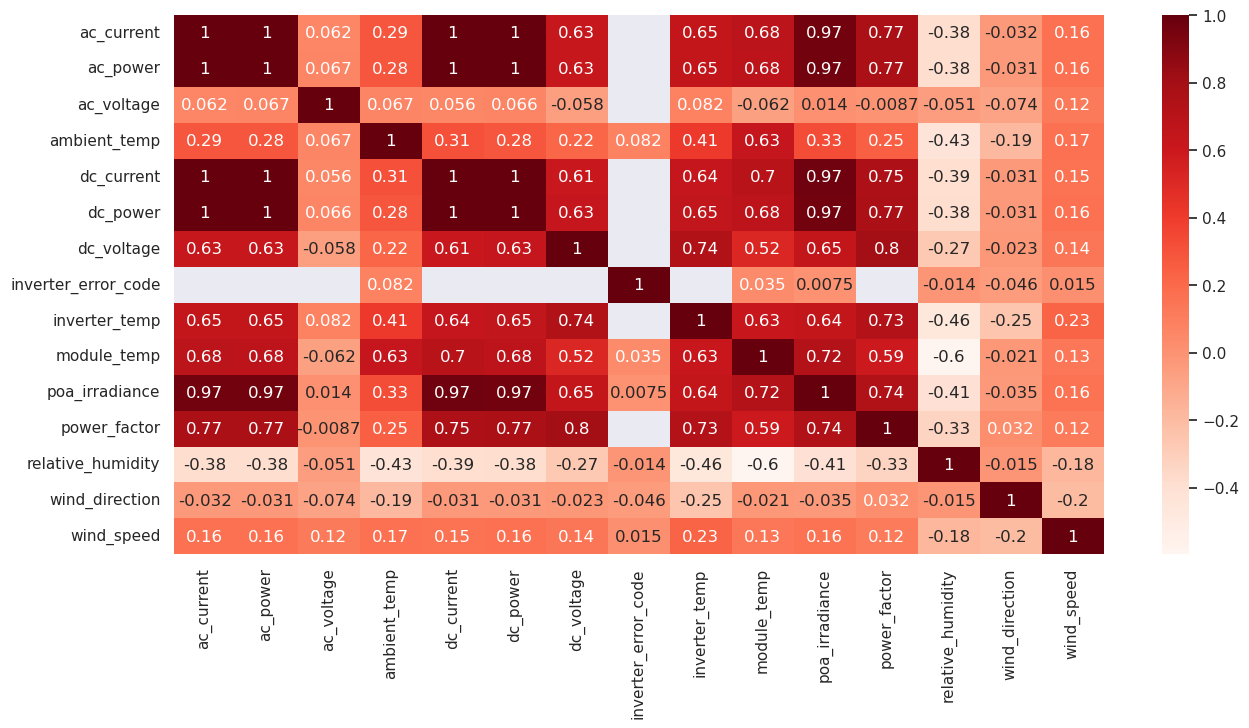

In [18]:
data_correlations_34 = system_34_data.corr()
sb.set(rc={'figure.figsize':(15, 7)})
sb.heatmap(data_correlations_34, cmap="Reds", annot=True)
plt.show()

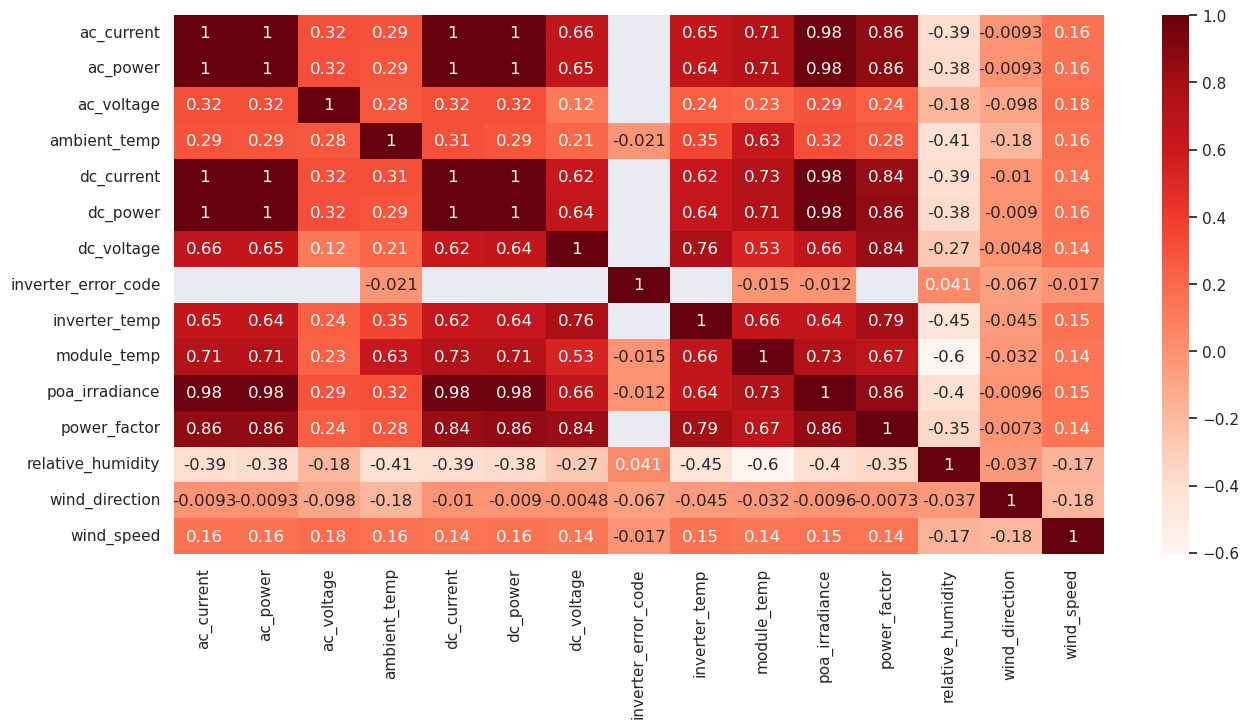

In [19]:
system_1276_correlations = system_1276_data.corr()
sb.set(rc={'figure.figsize':(15, 7)})
sb.heatmap(system_1276_correlations, cmap="Reds", annot=True)
plt.show()

The above correlation heat maps shows that most of the features have strong positive correlation, such as:

    - Irradiance with current and power, for both AC and DC
    - power with current, where correlation is almost 1
`ac_power` and `dc_power` are not used in the model, because they do not carry significant amount of new information.


Moderate correlation is present between the ambient temperature and the electrical parameters. Slightly higher values are seen between inverter temperate and the electrical parameters. 
Relative humidity has negative correlation coefficients, with higher values for `module_temp` and `poa_irradiance`. Wind speed and wind direction have relatively low correlation with the other parameters. 

For the `inverter_error_code` low correlation coefficients are present only for weather features, because there are no data from the electrical system when error code is present.

#### 2.3.b. Boxplots

In [20]:
columns_to_plot = ['ac_current', 'ac_voltage', 'ambient_temp', 'dc_current', 'dc_voltage', 'inverter_temp', 'module_temp', 'poa_irradiance', 'power_factor']

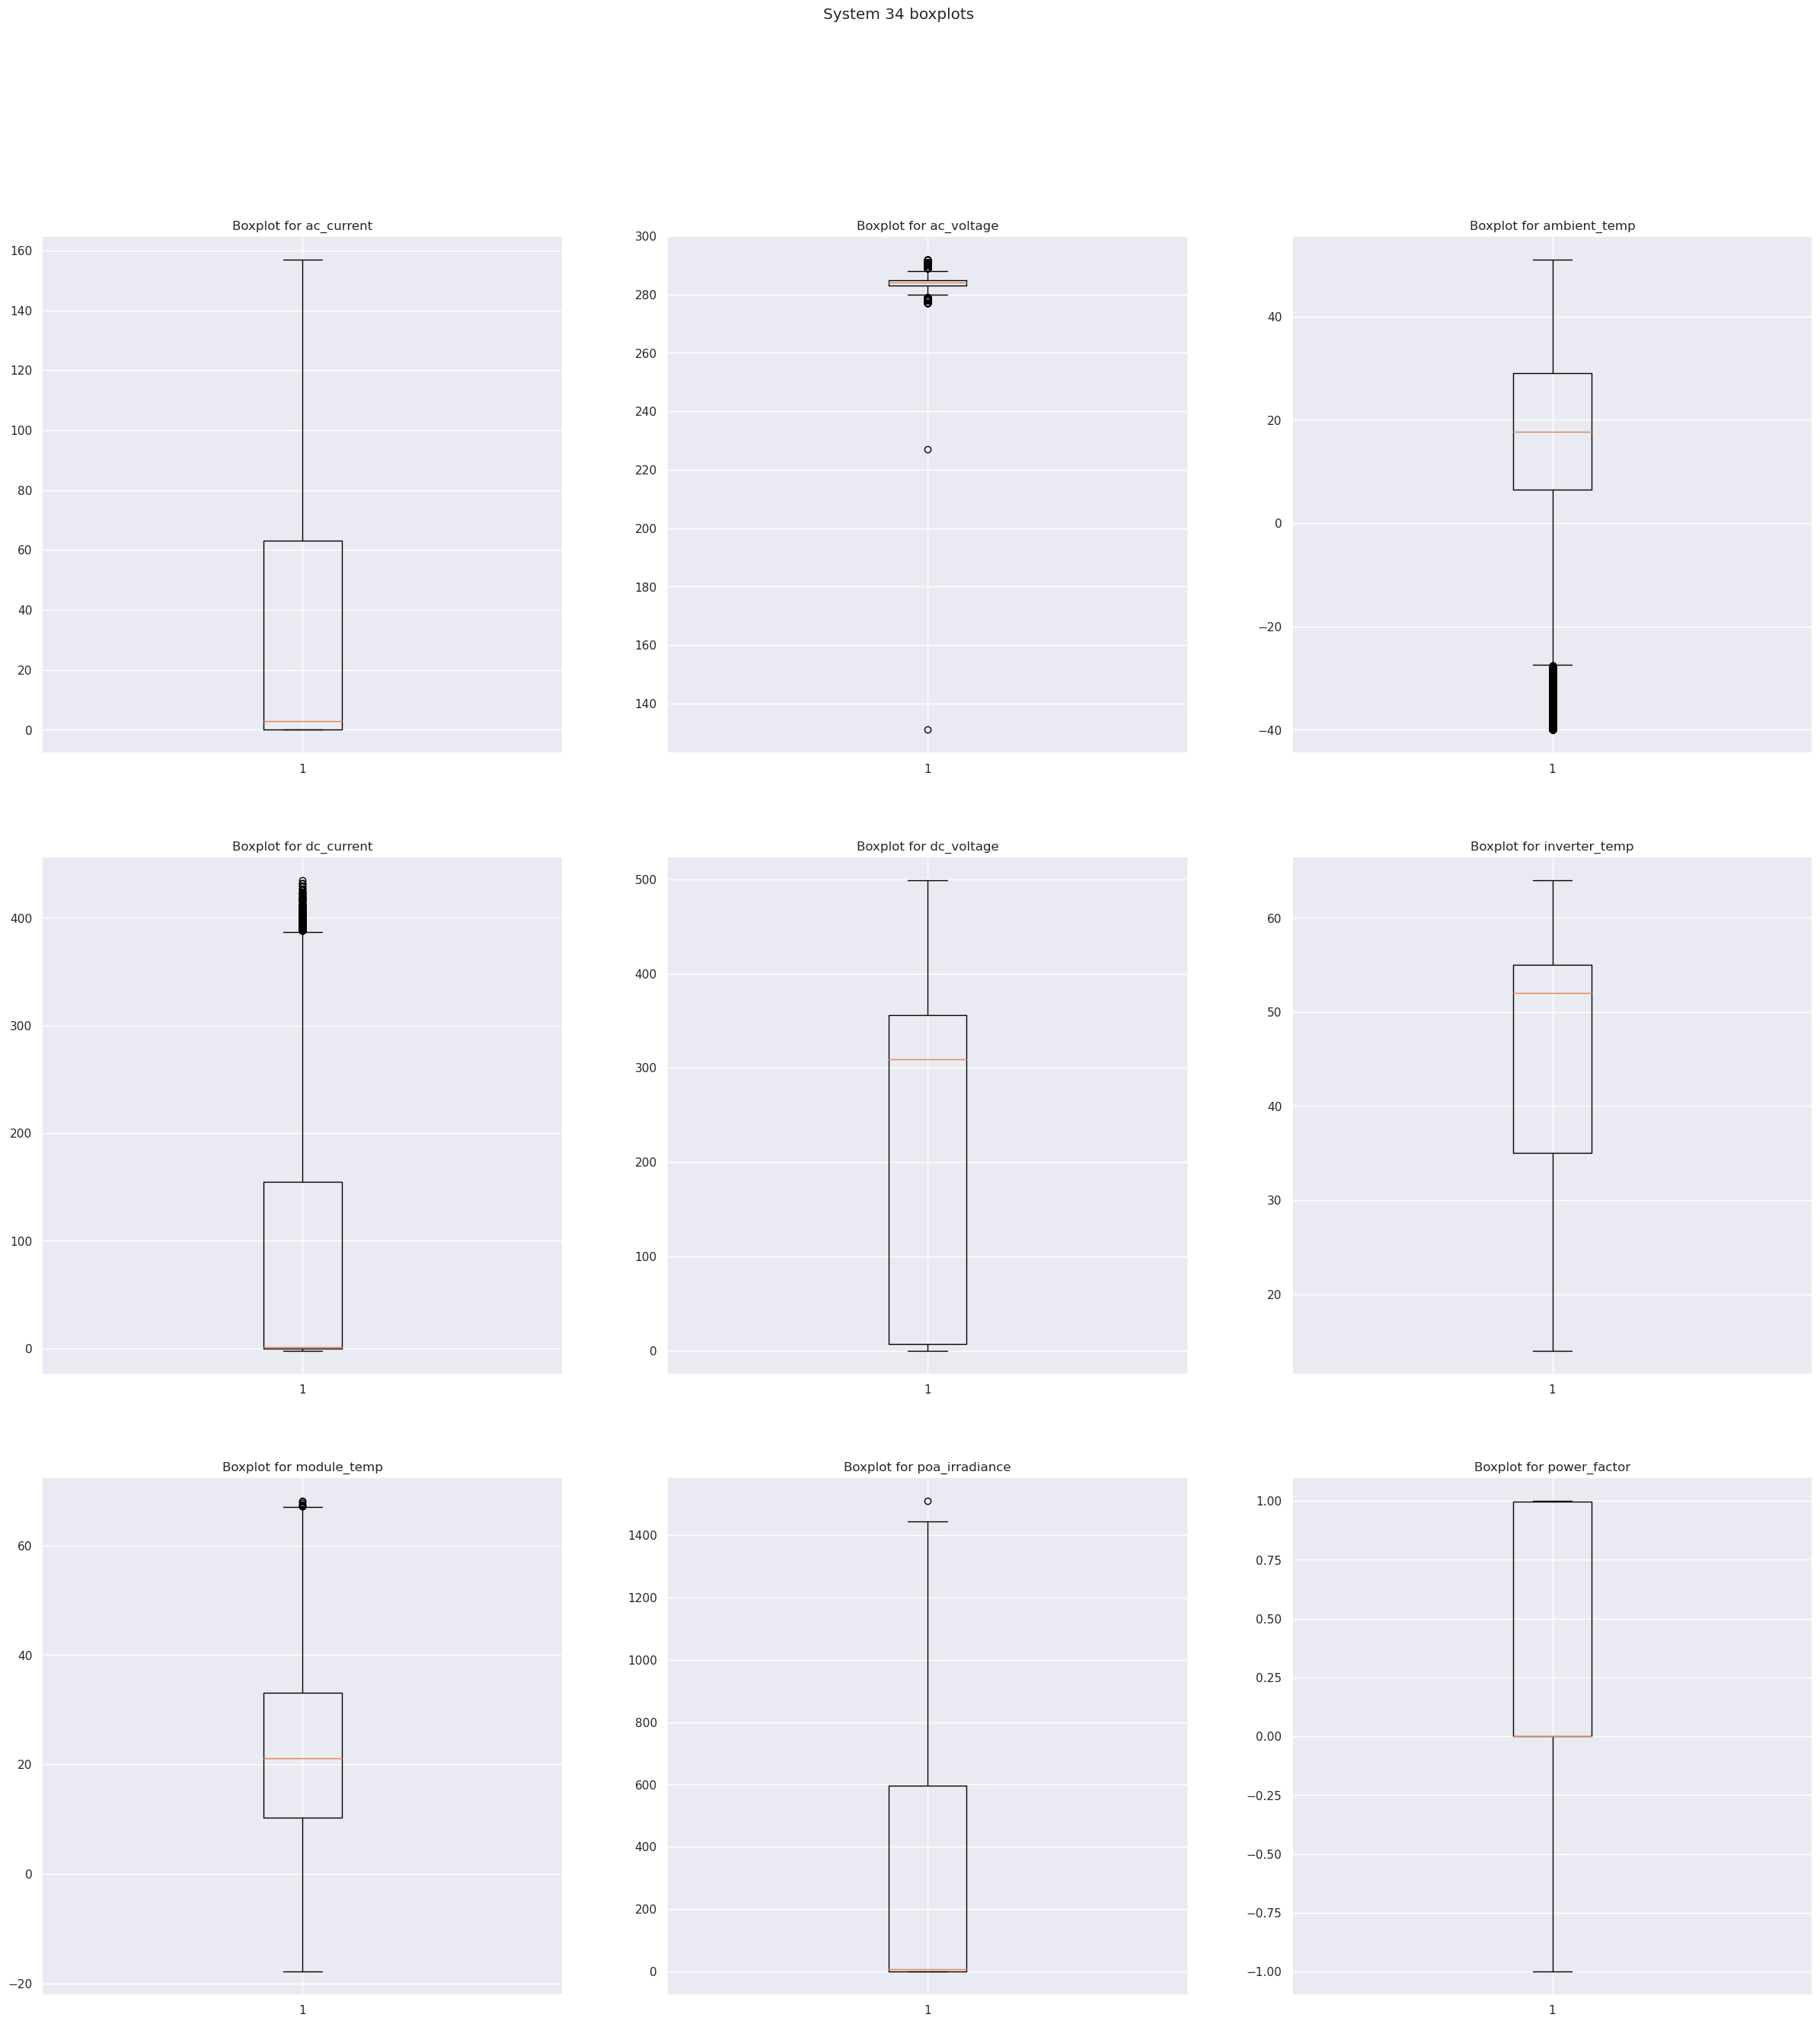

In [21]:
cf.subplot_boxplots(system_34_data, columns_to_plot, system_id=34)

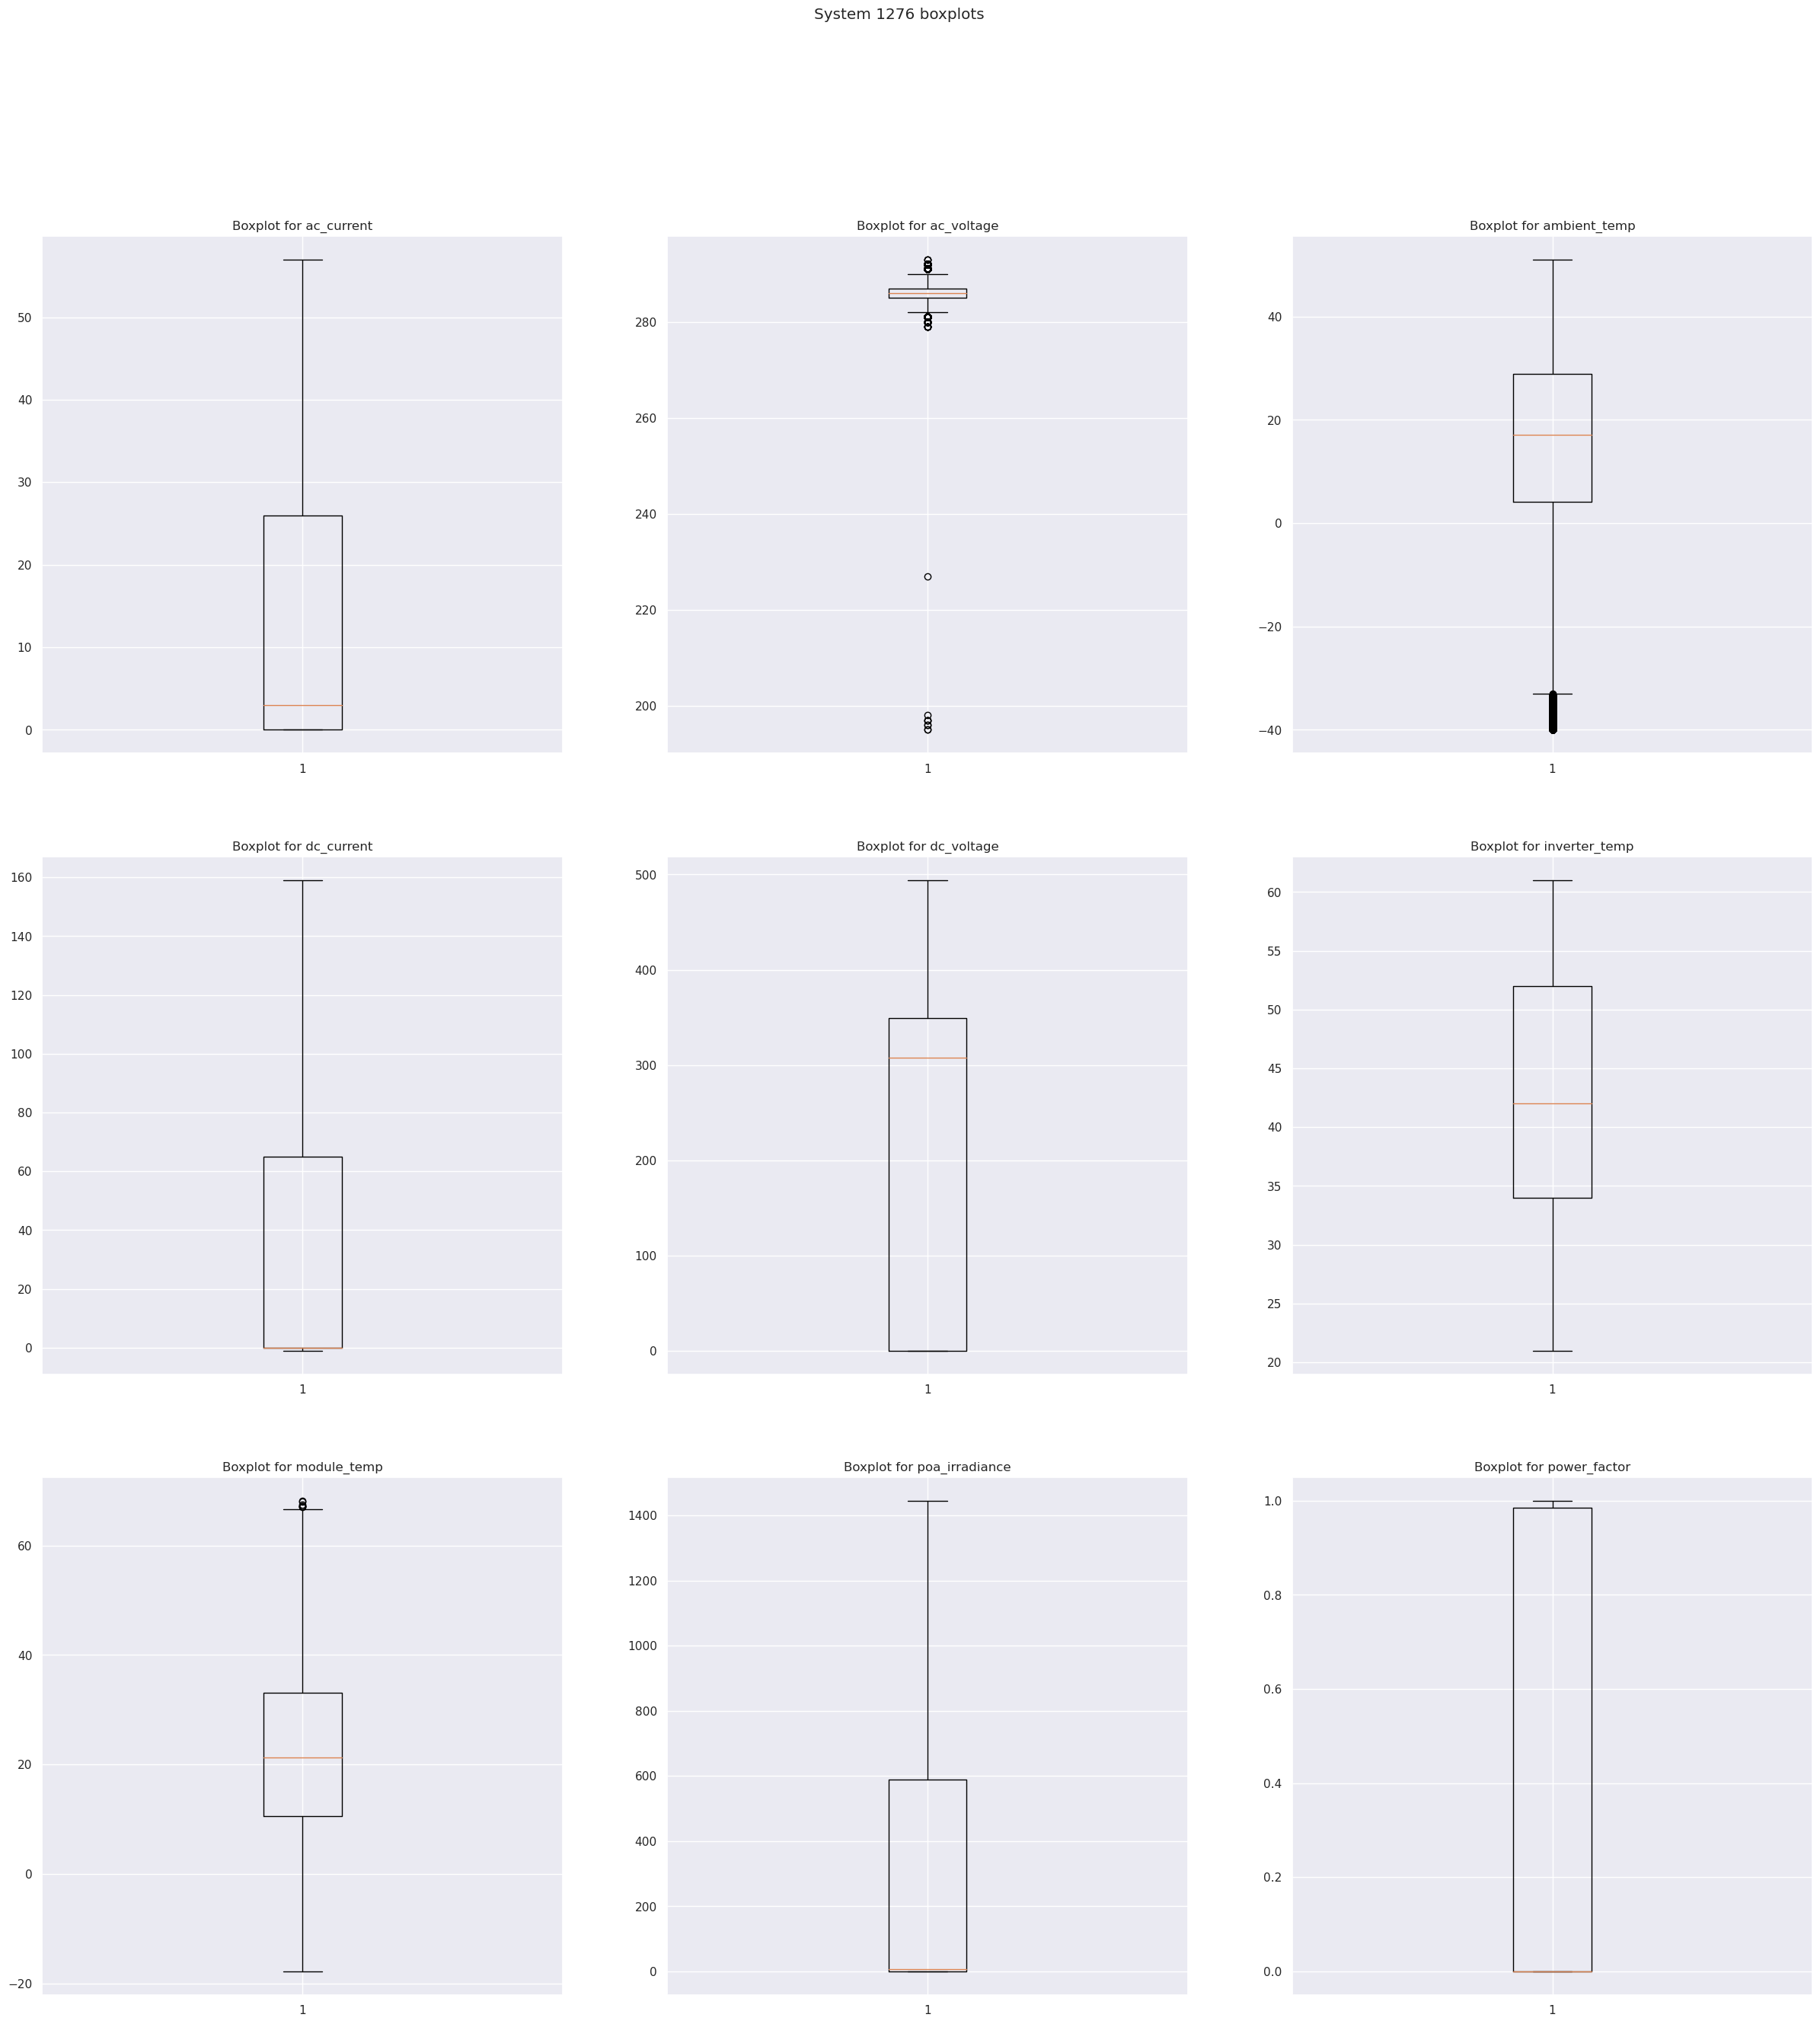

In [22]:
cf.subplot_boxplots(system_1276_data, columns_to_plot, system_id=1276)

For both systems outliers for the `ambient_temp` are present, when it has low negative values. The irradiance has similar distribution, because the location is the same. It has positive skew and approximately half of the values are 0, which is normal through the night. Difference between the highest value for the DC and AC current between the two system is present, but both have positive skew. AC voltage has small box, the data is close to the median and not widely spread, as expected, because the voltage injected to the grid should not vary with more that 7-10%. There are some outliers with values below 280. The power factor has wide distribution with median at 0. For system 34 negative values, which are abnormal, are present.

### Literature:
<a id=1></a> 1. https://www.nrel.gov/docs/fy19osti/73822.pdf

<a id=2></a> 2. https://toolsense.io/maintenance/the-6-types-of-maintenance-definitions-benefits-examples/

<a id=3></a> 3. ~/work/SoftUni_python/machine_learning/project/research/Final-Report-IEA-PVPS-T13-19_2021_PV-Failure-Monitoring.pdf

<a id=4></a> 4. https://omegasolarandbatteries.com.au/what-are-hot-spots/

<a id=5></a> 5. Livera, A.; Paphitis, G.; Theristis, M.; Lopez-Lorente, J.; Makrides, G.; Georghiou, G.E. Photovoltaic System Health-State Architecture for Data-Driven Failure Detection. Solar 2022, 2, 81-98. https://doi.org/10.3390/solar2010006

<a id=6></a>  6. Ibrahim, M.; Alsheikh, A.; Awaysheh, F.M.; Alshehri, M.D. Machine Learning Schemes for Anomaly Detection in Solar Power Plants. Energies 2022, 15, 1082. https://doi.org/10.3390/en15031082 

<a id=7></a>  7. Foorthuis, Ralph. (2021). On the nature and types of anomalies: a review of deviations in data. International Journal of Data Science and Analytics. 12. 1-35. 10.1007/s41060-021-00265-1. 

<a id=8></a> 8. Julien Lesouple, Cédric Baudoin, Marc Spigai, Jean-Yves Tourneret, Generalized isolation forest for anomaly detection, Pattern Recognition Letters, Volume 149,
2021, Pages 109-119, ISSN 0167-8655, https://doi.org/10.1016/j.patrec.2021.05.022.

<a id=9></a> 9. Liu, Fei Tony & Ting, Kai & Zhou, Zhi-Hua. (2009). Isolation Forest. 413 - 422. 10.1109/ICDM.2008.17.

<a id=10></a> 10. Branco, P.; Gonçalves, F.; Costa, A.C. Tailored Algorithms for Anomaly Detection in Photovoltaic Systems. Energies 2020, 13, 225. https://doi.org/10.3390/en13010225 